In [41]:
import pyAudioAnalysis


from pydub import AudioSegment

from os import listdir
from os.path import isfile, join

mypath = "./Samples/SES/"

onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

songs = []

for i in onlyfiles:
    song = AudioSegment.from_mp3(mypath+i)
    songs.append(song)




In [2]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.layers import Dropout
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from keras.optimizers import SGD
from sklearn.pipeline import Pipeline
from pyAudioAnalysis import audioBasicIO
from pyAudioAnalysis import audioFeatureExtraction
import os
import re
import matplotlib.pyplot as plt
from sklearn.externals import joblib

#Helper method
#assumption, we save a file somewhere.

def extract_features(file_path):

    [Fs, x] = audioBasicIO.readAudioFile(file_path)
    x= audioBasicIO.stereo2mono(x) #necessary conversion for pyaudio analysis
    features = audioFeatureExtraction.stFeatureExtraction(x, Fs, 0.05*Fs, 0.025*Fs)
    features = np.mean(features, axis=1)
    features = np.asarray(features).reshape(len(features),-1).transpose()
    #features_complete = np.append(features_complete, features, axis=0)
    return features #_complete

def extract_features2(Fs,x):
    x= audioBasicIO.stereo2mono(x) #necessary conversion for pyaudio analysis
    features = audioFeatureExtraction.stFeatureExtraction(x, Fs, 0.05*Fs, 0.025*Fs)
    features = np.mean(features, axis=1)
    features = np.asarray(features).reshape(len(features),-1).transpose()
    #features_complete = np.append(features_complete, features, axis=0)
    return features #_complete


def baseline_model(optimizer = 'adam',units=70, prop=0.3):
    # create model
    model = Sequential()
    model.add(Dense(input_dim=34, output_dim = units, activation='relu'))
    model.add(Dropout(prop))
    model.add(Dense(input_dim = units, output_dim = 7, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 950M (CNMeM is enabled with initial size: 80.0% of memory, cuDNN not available)


In [3]:
print song.frame_rate
print song.channels

from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json


model = baseline_model()
model.load_weights('./Samples/EmoDashANN_weights_v2.h5')
Rescaler = joblib.load('./Samples/featuresScaled.pkl')



8000
1


D:\Python2.7\lib\site-packages\ipykernel\__main__.py:45: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=70, activation="relu", input_dim=34)`
D:\Python2.7\lib\site-packages\ipykernel\__main__.py:47: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=7, activation="softmax", input_dim=70)`
D:\Python2.7\lib\site-packages\sklearn\base.py:312: UserWarning: Trying to unpickle estimator StandardScaler from version 0.18.1 when using version 0.19.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [40]:
import array
from pydub import AudioSegment
from pydub.utils import get_array_type
import pandas as pd
from matplotlib import pyplot as plt

#print(splitting.frame_rate)



def split_song(song):
    mydict = []
    for i in range(3000,len(song),3000):
        #print i
        splitting =song[i-3000:i] # first three seconds
        bit_depth = splitting.sample_width * 8
        array_type = get_array_type(bit_depth)
        numeric_array = array.array(array_type, splitting._data)
        numeric_array= numeric_array.tolist()
        features = extract_features2(splitting.frame_rate,np.asarray(numeric_array))
        features_transformed = Rescaler.transform(features)
        prediction = model.predict(features_transformed)[0]
        mydict.append({"Anger":prediction[0], "Disgust":prediction[1], "Fear":prediction[2], "Hapiness":prediction[3],"Neutral":prediction[4],  "Sadness":prediction[5], "Surprise":prediction[6] })

    data_frame_emotions = pd.DataFrame.from_dict(mydict)
    return data_frame_emotions

ses q1 2013.mp3


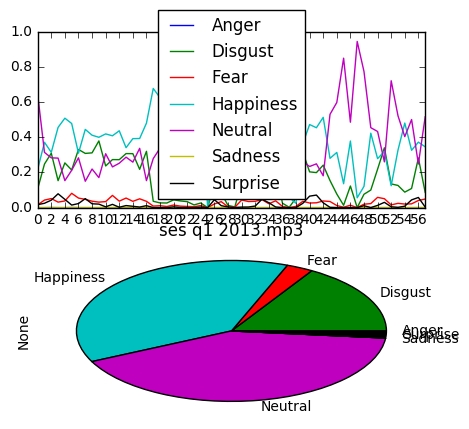

ses q1 2014.mp3


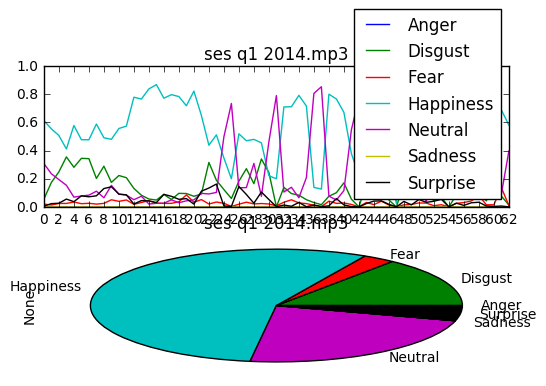

ses q1 2015.mp3


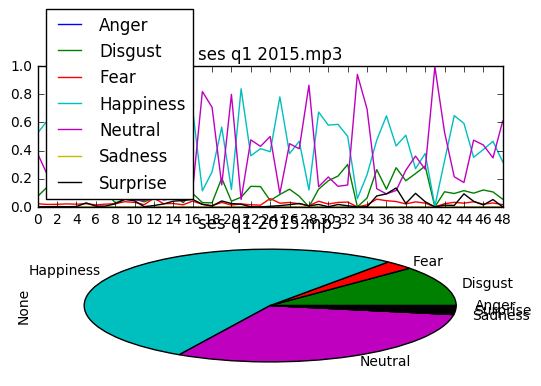

ses q1 2016.mp3


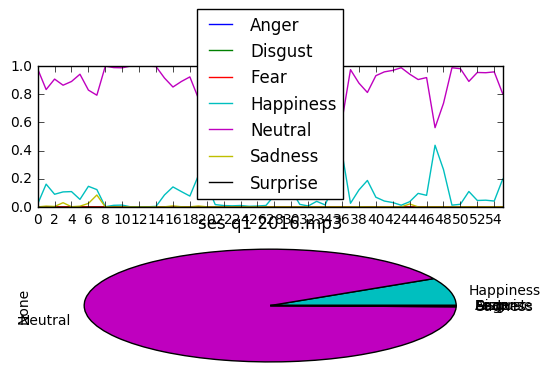

ses q1 2017.mp3


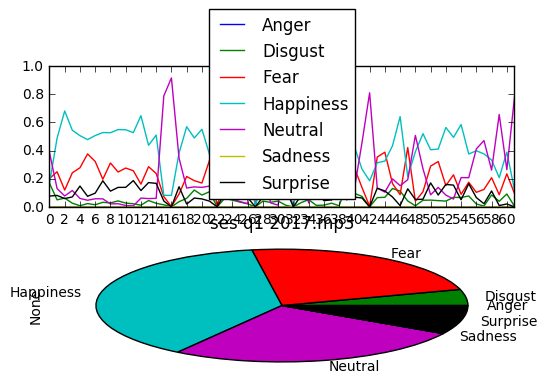

ses q2 2013.mp3


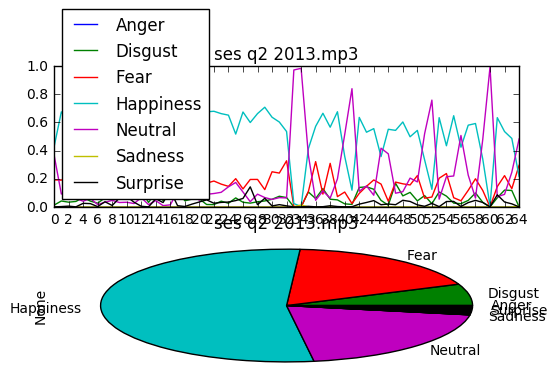

ses q2 2014.mp3


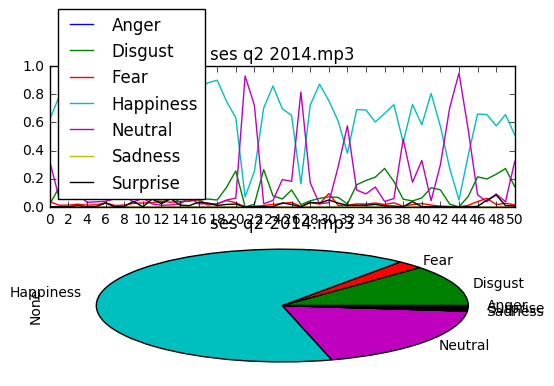

ses q2 2015.mp3


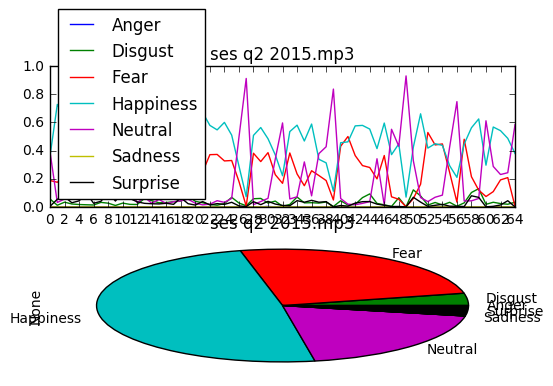

ses q2 2016.mp3


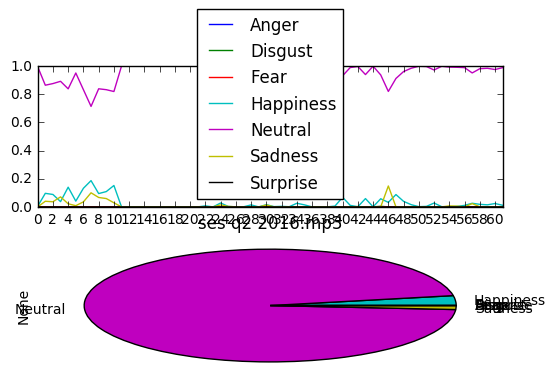

ses q3 2015.mp3


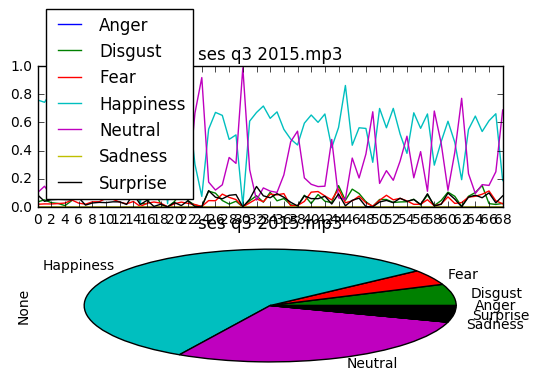

ses q3 2016.mp3


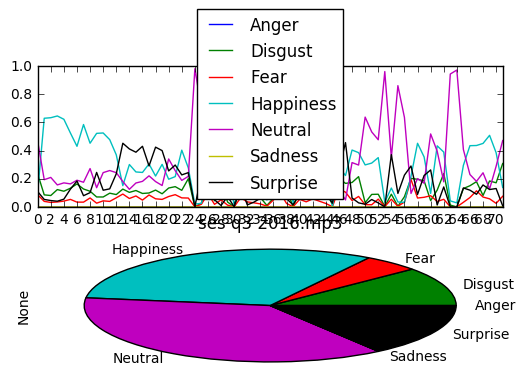

ses q4 2012.mp3


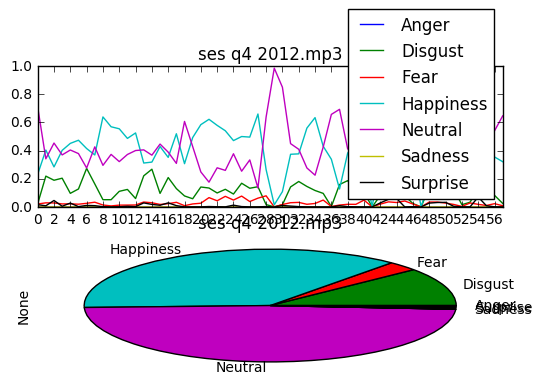

ses q4 2013.mp3


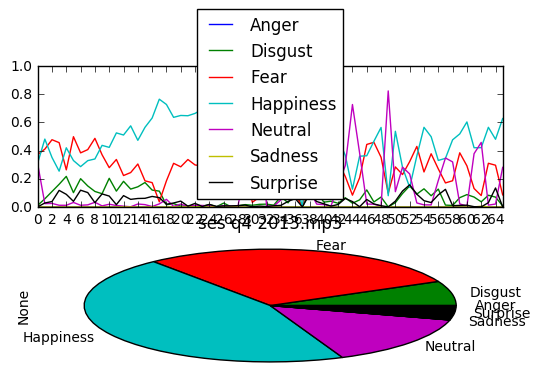

ses q4 2014.mp3


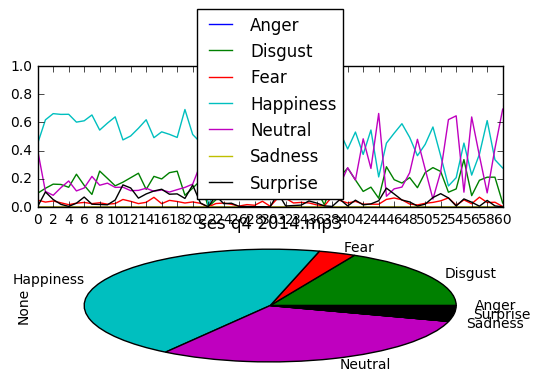

ses q4 2015.mp3


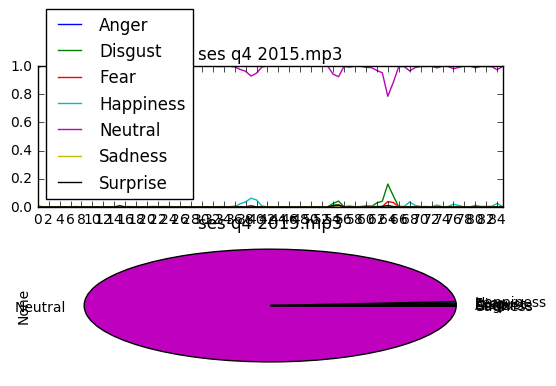

In [42]:
figure_n = 1

for myf,filename in zip(songs,onlyfiles):
    print filename
    data_frame_emotions=split_song(myf)
    data_frame_emotions.rename(columns={'Hapiness': 'Happiness'},inplace=True)
    final_frame=data_frame_emotions.groupby(np.arange(len(data_frame_emotions))//20).mean()
    plt.figure(figsize=(5,5))
    plt.figure(figure_n)
    fig = plt.subplot(2,1,1)
    fig.set_xticks(range(0,100,2))
    fig.set_title(filename)
    final_frame.plot(ax = fig)
    fig2 = plt.subplot(2,1,2)
    fig2.set_title(filename)
    data_frame_emotions.mean().plot.pie(ax = fig2)
    figure_n += 1
    plt.show()

In [39]:
#for myf,filename in zip(songs,onlyfiles):
#print onlyfiles

plt.close()
#index=9
myf = songs[0]
filename = mypath #onlyfiles[index]

print filename


data_frame_emotions=split_song(myf)
data_frame_emotions.rename(columns={'Hapiness': 'Happiness'},inplace=True)
final_frame=data_frame_emotions.groupby(np.arange(len(data_frame_emotions))//20).mean()
plt.figure(figsize=(10,10))
fig = plt.subplot(2,1,1)
fig.set_xticks(range(0,100,2))
fig.set_title(filename)
final_frame.plot(ax = fig)
fig2 = plt.subplot(2,1,2)
data_frame_emotions.mean().plot.pie(ax=fig2)
    
plt.show()

./Samples/SES/ses q4 2015.mp3


KeyboardInterrupt: 

In [22]:
plt.show()